In [28]:
# !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


In [29]:
# !pip install pycocotools
# !pip install -U -q datasets transformers[torch] timm wandb torchmetrics matplotlib albumentations



In [30]:
# !pip install -q gdown
# !gdown --id 1pJ3xfKtHiTdysX5G3dxqKTdGESOBYCxJ --output "./AU-AIR.zip"

In [31]:
# import zipfile

# with zipfile.ZipFile("./AU-AIR.zip", 'r') as zip_ref:
#     zip_ref.extractall("./AU-AIR")


In [32]:
# !mkdir -p annotations

In [33]:
# import json

# with open('./annotations/annotations.json') as f:
#     data = json.load(f)

In [34]:
import os
import torch
import wandb
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax
import albumentations as A

# Preprocessing

### Clean the keys of annotations from ':'.

In [35]:
import json

# File paths
input_path = "./annotations/annotations.json"
output_path = "./annotations/annotations.json"

# Recursive function to clean dictionary keys
def clean_keys(obj):
    if isinstance(obj, dict):
        return {k.rstrip(":"): clean_keys(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [clean_keys(i) for i in obj]
    else:
        return obj

# Load original data
with open(input_path, "r") as f:
    raw_data = json.load(f)

# Clean all keys
cleaned_data = clean_keys(raw_data)

# Save cleaned data
with open(output_path, "w") as f:
    json.dump(cleaned_data, f, indent=4)

print(f"✅ Cleaned annotations saved to: {output_path}")


✅ Cleaned annotations saved to: ./annotations/annotations.json


### Convert the annotations to COCO format

In [36]:
import json
import os

# Step 1: Load cleaned annotation file
with open("./annotations/annotations.json", "r") as f:
    auair_data = json.load(f)

# Step 2: Convert to COCO format
def convert_auair_to_coco(auair_data, output_path="auair_coco.json"):
    images = []
    annotations = []

    # Define COCO-style categories from class names
    categories = [{"id": i, "name": name} for i, name in enumerate(auair_data["categories"])]

    ann_id = 1  # unique annotation ID
    for img_id, entry in enumerate(auair_data["annotations"], start=1):
        image_name = entry["image_name"]
        width = entry["image_width"]
        height = entry["image_height"]

        images.append({
            "id": img_id,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        for bbox in entry["bbox"]:
            x = bbox["left"]
            y = bbox["top"]
            w = bbox["width"]
            h = bbox["height"]
            category_id = bbox["class"]

            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": category_id,
                "bbox": [x, y, w, h],       # COCO: [x, y, width, height]
                "area": w * h,
                "iscrowd": 0
            })
            ann_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    # Step 3: Save to COCO format JSON file
    with open(output_path, "w") as f:
        json.dump(coco_data, f, indent=4)

    print(f"✅ COCO-format annotations saved to: {output_path}")

# Step 4: Run the conversion
convert_auair_to_coco(
    auair_data,
    output_path="./annotations/auair_coco.json"
)


✅ COCO-format annotations saved to: ./annotations/auair_coco.json


### Filter the COCO annotations such that images that are not annotated and/or annotated but no image file exists

In [37]:
import os
import json

# === PATHS ===
image_folder = "./AU-AIR/images"
annotation_file = "./annotations/auair_coco.json"
filtered_annotation_path = "./annotations/auair_coco_filtered.json"

# === LOAD ANNOTATION ===
with open(annotation_file, "r") as f:
    coco = json.load(f)

# === IMAGE NAME CHECKS ===
annotated_image_names = set(img["file_name"] for img in coco["images"])
image_files = set(os.listdir(image_folder))

missing_images = annotated_image_names - image_files
unannotated_images = image_files - annotated_image_names

# === REPORT ===
print(f"✅ Total annotated images: {len(annotated_image_names)}")
print(f"📂 Total actual image files: {len(image_files)}\n")

print(f"❌ Missing image files (in annotations but not found on disk): {len(missing_images)}")
if missing_images:
    print("Examples:", sorted(list(missing_images))[:5])

print(f"📝 Unannotated image files (exist in folder but not in annotations): {len(unannotated_images)}")
if unannotated_images:
    print("Examples:", sorted(list(unannotated_images))[:5])

# === FILTER ANNOTATIONS ===
valid_images = [img for img in coco["images"] if img["file_name"] in image_files]
valid_image_ids = set(img["id"] for img in valid_images)
valid_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in valid_image_ids]

filtered_coco = {
    "images": valid_images,
    "annotations": valid_annotations,
    "categories": coco["categories"]
}

# === SAVE CLEANED JSON ===
with open(filtered_annotation_path, "w") as f:
    json.dump(filtered_coco, f, indent=4)

print(f"\n✅ Filtered COCO annotations saved to: {filtered_annotation_path}")
print(f"➡️ Valid images remaining: {len(valid_images)}")
print(f"➡️ Valid annotations remaining: {len(valid_annotations)}")


✅ Total annotated images: 32823
📂 Total actual image files: 32823

❌ Missing image files (in annotations but not found on disk): 0
📝 Unannotated image files (exist in folder but not in annotations): 0

✅ Filtered COCO annotations saved to: ./annotations/auair_coco_filtered.json
➡️ Valid images remaining: 32823
➡️ Valid annotations remaining: 132031


In [38]:
import json

# Input and output file paths
input_path = "./annotations/auair_coco_filtered.json"
output_path = "./annotations/auair_coco_cleaned.json"

# Load COCO annotations
with open(input_path, "r") as f:
    coco = json.load(f)

valid_annotations = []
invalid_count = 0

for ann in coco["annotations"]:
    x, y, w, h = ann["bbox"]
    if w > 0 and h > 0:
        valid_annotations.append(ann)
    else:
        invalid_count += 1
        print(f"❌ Invalid bbox removed: id={ann['id']} bbox={ann['bbox']}")

# Keep the same image and category sections
cleaned_coco = {
    "images": coco["images"],
    "annotations": valid_annotations,
    "categories": coco["categories"]
}

# Save to new cleaned file
with open(output_path, "w") as f:
    json.dump(cleaned_coco, f, indent=4)

print(f"\n✅ Cleaned annotations saved to: {output_path}")
print(f"➡️ Total valid annotations: {len(valid_annotations)}")
print(f"🚫 Total invalid annotations removed: {invalid_count}")


❌ Invalid bbox removed: id=108 bbox=[1892, 0, 0, 0]
❌ Invalid bbox removed: id=111 bbox=[874, 689, 0, 0]
❌ Invalid bbox removed: id=3453 bbox=[1022, 185, 0, 0]
❌ Invalid bbox removed: id=10683 bbox=[1563, 1080, 0, 0]
❌ Invalid bbox removed: id=24501 bbox=[677, 398, 0, 0]
❌ Invalid bbox removed: id=24502 bbox=[680, 389, 0, 0]
❌ Invalid bbox removed: id=25837 bbox=[559, 797, 0, 0]
❌ Invalid bbox removed: id=28448 bbox=[795, 699, 0, 0]
❌ Invalid bbox removed: id=28456 bbox=[1760, 290, 0, 0]
❌ Invalid bbox removed: id=30016 bbox=[691, 995, 0, 0]
❌ Invalid bbox removed: id=30017 bbox=[725, 932, 0, 0]
❌ Invalid bbox removed: id=30018 bbox=[696, 927, 0, 0]
❌ Invalid bbox removed: id=31110 bbox=[1205, 1080, 0, 0]
❌ Invalid bbox removed: id=31111 bbox=[1495, 1080, 0, 0]
❌ Invalid bbox removed: id=31113 bbox=[1685, 382, 0, 0]
❌ Invalid bbox removed: id=41260 bbox=[1640, 347, 0, 0]
❌ Invalid bbox removed: id=48670 bbox=[802, 98, 0, 4]
❌ Invalid bbox removed: id=72018 bbox=[901, 599, 0, 0]
❌ Inval

C:\Users\Ali\AppData\Local\Temp\ipykernel_22968\1357501636.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=45, ha="right")


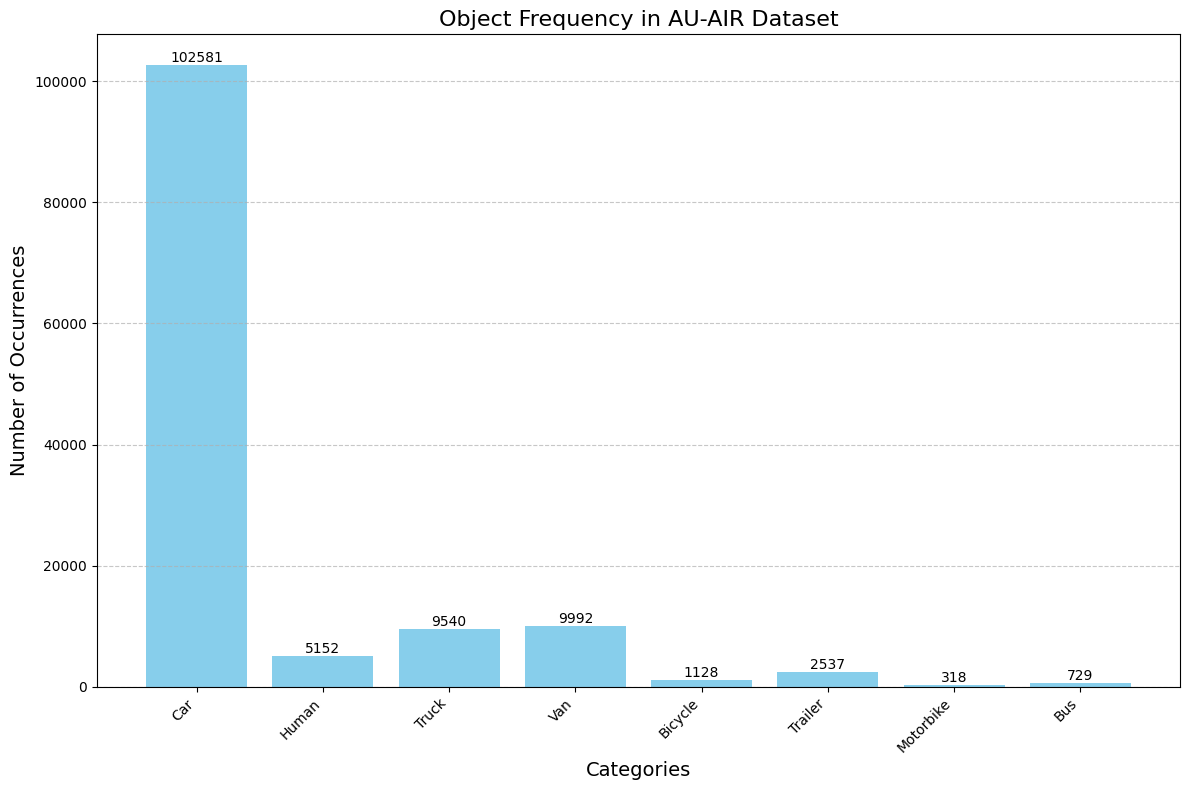

In [39]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# AU-AIR class mapping (adjust if different)
id2label = {
    0: "Human",
    1: "Car",
    2: "Truck",
    3: "Van",
    4: "Motorbike",
    5: "Bicycle",
    6: "Bus",
    7: "Trailer"
}
label2id = {v: k for k, v in id2label.items()}

# Load cleaned annotation file
with open("./annotations/auair_coco_cleaned.json", "r") as f:
    coco = json.load(f)

# Count class occurrences
class_counts = Counter()
for ann in coco["annotations"]:
    class_counts[ann["category_id"]] += 1

# Prepare for plotting
categories = [id2label[i] for i in class_counts.keys()]
values = list(class_counts.values())

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(categories, values, color="skyblue")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Object Frequency in AU-AIR Dataset", fontsize=16)
ax.set_xticklabels(categories, rotation=45, ha="right")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [40]:
from sklearn.model_selection import train_test_split
import random
import json

# Load full COCO data
with open("./annotations/auair_coco_cleaned.json", "r") as f:
    coco = json.load(f)

# Get all image IDs
all_images = coco["images"]
train_imgs, testval_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

# Utility to get annotations for given image list
def get_anns_for_imgs(images, all_anns):
    img_ids = set(img["id"] for img in images)
    return [ann for ann in all_anns if ann["image_id"] in img_ids]

# Create new COCO-style splits
def save_split(name, images, anns):
    data = {
        "images": images,
        "annotations": anns,
        "categories": coco["categories"]
    }
    with open(f"./annotations/auair_coco_{name}.json", "w") as f:
        json.dump(data, f, indent=4)
    print(f"✅ {name} split saved with {len(images)} images and {len(anns)} annotations.")

save_split("train", train_imgs, get_anns_for_imgs(train_imgs, coco["annotations"]))
save_split("val", val_imgs, get_anns_for_imgs(val_imgs, coco["annotations"]))
save_split("test", test_imgs, get_anns_for_imgs(test_imgs, coco["annotations"]))


✅ train split saved with 26258 images and 105274 annotations.
✅ val split saved with 3282 images and 13433 annotations.
✅ test split saved with 3283 images and 13270 annotations.


In [54]:
import json
from collections import defaultdict
from tqdm import tqdm
import random

# Load the COCO-style annotation file
with open("./annotations/auair_coco_train.json", "r") as f:
    coco = json.load(f)

# Step 1: Map each image_id to the set of category_ids it contains
image_categories = defaultdict(set)
for ann in coco["annotations"]:
    image_categories[ann["image_id"]].add(ann["category_id"])

# Step 2: Identify image_ids that contain only 'Car' (category_id = 1)
only_car_ids = [img_id for img_id, cats in image_categories.items() if cats == {1}]
print(f"🚗 Number of images containing only 'Car': {len(only_car_ids)}")

# Step 3: Select a fraction (e.g., 20%) to retain
retain_ratio = 0.2
retain_count = int(len(only_car_ids) * retain_ratio)
only_car_ids_sampled = set(random.sample(only_car_ids, retain_count))
print(f"✅ Number of retained 'only-Car' images after downsampling: {len(only_car_ids_sampled)}")

# Step 4: Filter the image list to exclude dropped-only-Car images
filtered_images = []
filtered_image_ids = set()
for img in coco["images"]:
    if img["id"] not in only_car_ids or img["id"] in only_car_ids_sampled:
        filtered_images.append(img)
        filtered_image_ids.add(img["id"])

# Step 5: Filter annotations based on the retained image_ids
filtered_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in filtered_image_ids]

# Step 6: Create the new COCO-format dictionary
filtered_coco = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": coco["categories"]
}

# Step 7: Save the balanced annotation file
output_path = "./annotations/auair_coco_train.json"
with open(output_path, "w") as f:
    json.dump(filtered_coco, f, indent=4)

print(f"\n🎯 Balanced train set saved to: {output_path}")
print(f"🖼️ Total remaining images: {len(filtered_images)}")
print(f"✏️ Total remaining annotations: {len(filtered_annotations)}")


🚗 Number of images containing only 'Car': 11577
✅ Number of retained 'only-Car' images after downsampling: 2315

🎯 Balanced train set saved to: ./annotations/auair_coco_train.json
🖼️ Total remaining images: 16996
✏️ Total remaining annotations: 80060


In [55]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from torchvision import transforms
from PIL import Image
import numpy as np

class AUAirCocoDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None):
        super().__init__(img_folder, ann_file)
        self.transform = transform

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        w, h = img.size

        boxes = []
        class_labels = []

        for obj in target:
            x, y, width, height = obj["bbox"]
            if width > 0 and height > 0:
                boxes.append([x, y, x + width, y + height])
                class_labels.append(obj["category_id"])

        img_np = np.array(img)

        if self.transform:
            transformed = self.transform(
                image=img_np,
                bboxes=boxes,
                category=class_labels
            )
            img_np = transformed["image"]
            boxes = transformed["bboxes"]
            class_labels = transformed["category"]

        img_tensor = transforms.ToTensor()(img_np)
        # image_id = target[0]["image_id"]

        normalized_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            x1 /= w
            x2 /= w
            y1 /= h
            y2 /= h
            normalized_boxes.append([x1, y1, x2, y2])

        target = {
            "boxes": torch.tensor(normalized_boxes, dtype=torch.float32),
            "class_labels": torch.tensor(class_labels, dtype=torch.int64),  # ✅ key name değişti
            "image_id": torch.tensor([self.ids[idx]]),
            "area": torch.tensor([(x2 - x1) * (y2 - y1) for x1, y1, x2, y2 in boxes], dtype=torch.float32),
            "iscrowd": torch.zeros(len(boxes), dtype=torch.int64),
            "orig_size": torch.tensor([h, w], dtype=torch.int64)
        }


        return img_tensor, target



In [56]:
import albumentations as A

# For training
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),
        A.Resize(500, 500),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"])
)

# For validation/test (no augmentation)
val_transform = A.Compose(
    [
        A.Resize(500, 500),

    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"])
)


In [57]:
train_dataset = AUAirCocoDataset(
    img_folder="./AU-AIR/images",
    ann_file="./annotations/auair_coco_train.json",
    transform=train_transform
)

val_dataset = AUAirCocoDataset(
    img_folder="./AU-AIR/images",
    ann_file="./annotations/auair_coco_val.json",
    transform=val_transform
)

test_dataset = AUAirCocoDataset(
    img_folder="./AU-AIR/images",
    ann_file="./annotations/auair_coco_test.json",
    transform=val_transform
)


loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [58]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images = [item[0] for item in batch] 
    labels = [item[1] for item in batch]
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [59]:
import wandb

# Initialize W&B
wandb.init(
    project="DI725_Assignment2_FineTune",
    name="detr-resnet-50-auair-finetuned",
    config={
        "model": "facebook/detr-resnet-50-dc5",
        "batch_size": 4,
        "eval_steps": 50,
        "max_steps": 10000,
        "learning_rate": 1e-5,
        "weight_decay": 1e-4
    }
)


Step200_val_loss,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▇▆▆▆▅▅▄▄▅▄▄▂▂▂▂▃▃▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▁▄
train_loss_50avg,█▅▂▂▂▁▁▂
Step200_val_loss,2.38061
learning_rate,1e-05
train_loss,3.09872
train_loss_50avg,2.47513


In [60]:
import wandb
import torch
from torch.nn.functional import softmax
from transformers import AutoModelForObjectDetection

wandb.init(
    project="DI725_Assignment2_FineTune",
    name="detr-resnet-50-dc5-auair",
)

checkpoint = "facebook/detr-resnet-50-dc5"
id2label = {
    0: "Human", 1: "Car", 2: "Truck", 3: "Van",
    4: "Motorbike", 5: "Bicycle", 6: "Bus", 7: "Trailer"
}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to("cuda")


Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [47]:
# ================================
# 7. Helper Functions
# ================================
def denormalize_boxes(boxes, width, height):
    boxes[:, [0, 2]] *= width
    boxes[:, [1, 3]] *= height
    return boxes

def compute_map(preds, labels):
    metric = MeanAveragePrecision(box_format="xywh", class_metrics=True)
    metric.update(preds=preds, target=labels)
    return metric.compute()

def log_map_table(metrics, split="Validation"):
    table = wandb.Table(columns=[
        "Model", "Human", "Car", "Truck", "Van",
        "M.bike", "Bicycle", "Bus", "Trailer", "mAP"
    ])
    row = [
        "DETR-ResNet50",
        round(metrics.get("map_Human", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Car", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Truck", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Van", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Motorbike", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Bicycle", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Bus", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map_Trailer", torch.tensor(0.0)).item() * 100, 2),
        round(metrics.get("map", torch.tensor(0.0)).item() * 100, 2)
    ]
    table.add_data(*row)
    wandb.log({f"{split}_mAP_Table": table})


In [52]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

def train(model, train_loader, val_loader, optimizer, device, epochs=5, test_loader=None):
    global_step = 0
    scheduler = StepLR(optimizer, step_size=2, gamma=0.5) 

    def run_interim_validation(step_tag="Interim"):
        model.eval()
        val_loss, preds, gts = 0, [], []
        val_pbar = tqdm(val_loader, desc=f"{step_tag} Validation", leave=True)
        with torch.no_grad():
            for images, targets in val_pbar:
                images = torch.stack([img.to(device) for img in images])
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = model(pixel_values=images, labels=targets)
                val_loss += outputs.loss.item()

                logits = outputs.logits
                pred_scores = logits.softmax(-1)[..., :-1]
                pred_boxes = outputs.pred_boxes

                for i in range(len(images)):
                    width, height = targets[i]["orig_size"]
                    boxes = denormalize_boxes(pred_boxes[i].detach().clone(), width, height)
                    labels = pred_scores[i].argmax(-1)
                    scores = pred_scores[i].max(-1).values
                    print(f"DEBUG Sample pred_labels: {labels}")


                    preds.append({"boxes": boxes, "scores": scores, "labels": labels})
                    print(f"DEBUG Target[{i}] class_labels:", targets[i]["class_labels"])
                    gts.append({
                        "boxes": denormalize_boxes(targets[i]["boxes"].detach().clone(), width, height),
                        "labels": targets[i]["class_labels"].clone()
                    })
        print(f"✅ {step_tag} validation done at step {global_step}")
        wandb.log({f"{step_tag}_val_loss": val_loss / len(val_loader)}, step=global_step)
        metrics = compute_map(preds, gts)
        log_map_table(metrics, split=f"{step_tag} Validation")

    for epoch in range(epochs):
        model.train()
        running_loss, batch_losses = 0, []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for i, (images, targets) in pbar:
            images = torch.stack([img.to(device) for img in images])
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(pixel_values=images, labels=targets)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())
            wandb.log({
                "train_loss": loss.item(),
                "learning_rate": scheduler.get_last_lr()[0]
            }, step=global_step)

            if global_step > 0 and global_step % 50 == 0:
                avg_50 = sum(batch_losses[-50:]) / 50
                wandb.log({"train_loss_50avg": avg_50}, step=global_step)

            if global_step > 0 and global_step % 200 == 0:
                run_interim_validation(step_tag=f"Step{global_step}")

            pbar.set_postfix({
                "batch_loss": loss.item(),
                "avg_loss": running_loss / (i + 1),
                "lr": scheduler.get_last_lr()[0]
            })
            global_step += 1

        scheduler.step()  # Update LR at the edn of Epoch
        wandb.log({"train_loss_epoch_avg": running_loss / len(train_loader)}, step=global_step)

        # ===== End of Epoch =====
        run_interim_validation(step_tag=f"Epoch{epoch+1}")

    # ========== TEST EVALUATION ==========
    if test_loader:
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc="Testing")
            for images, targets in test_pbar:
                images = torch.stack([img.to(device) for img in images])
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = model(pixel_values=images, labels=targets)
                logits = outputs.logits
                pred_scores = logits.softmax(-1)[..., :-1]
                pred_boxes = outputs.pred_boxes

                for i in range(len(images)):
                    width, height = targets[i]["orig_size"]
                    boxes = denormalize_boxes(pred_boxes[i].detach().clone(), width, height)
                    labels = pred_scores[i].argmax(-1)
                    scores = pred_scores[i].max(-1).values

                    preds.append({"boxes": boxes, "scores": scores, "labels": labels})
                    print(f"DEBUG Target[{i}] class_labels:", targets[i]["class_labels"])
                    gts.append({
                        "boxes": denormalize_boxes(targets[i]["boxes"].detach().clone(), width, height),
                        "labels": targets[i]["class_labels"].clone()
                    })

        test_metrics = compute_map(preds, gts)
        log_map_table(test_metrics, split="Test")


In [ ]:
# ================================
# 9. Run Training
# ================================
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
train(model, train_loader, val_loader, optimizer, device="cuda", epochs=6, test_loader=test_loader)


Epoch 1/6:   2%|▏         | 95/4249 [00:56<40:49,  1.70it/s, batch_loss=4.02, avg_loss=4.67, lr=1e-5] 

In [ ]:
# ================================
# 10. Final Test Evaluation
# ================================
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to("cuda") for img in images]
        targets = [{k: v.to("cuda") for k, v in t.items()} for t in targets]

        outputs = model(images)
        logits = outputs.logits
        pred_scores = logits.softmax(-1)[..., :-1]
        pred_boxes = outputs.pred_boxes

        for i in range(len(images)):
            width, height = targets[i]["orig_size"]
            boxes = denormalize_boxes(pred_boxes[i].detach().clone(), width, height)
            labels = pred_scores[i].argmax(-1)
            scores = pred_scores[i].max(-1).values

            test_preds.append({"boxes": boxes, "scores": scores, "labels": labels})
            test_targets.append({
                "boxes": denormalize_boxes(targets[i]["boxes"].detach().clone(), width, height),
                "labels": targets[i]["labels"]
            })

test_metrics = compute_map(test_preds, test_targets)
log_map_table(test_metrics, split="Test")

In [ ]:
def train(model, train_loader, val_loader, optimizer, device, epochs=5):
    global_step = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        batch_losses = []

        for i, (images, targets) in enumerate(train_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            loss_dict = model.compute_loss(outputs, targets)
            loss = sum(loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())
            wandb.log({"train_loss": loss.item()}, step=global_step)

            if global_step > 0 and global_step % 50 == 0:
                avg_50 = sum(batch_losses[-50:]) / 50
                wandb.log({"train_loss_50avg": avg_50}, step=global_step)

            global_step += 1

        wandb.log({"train_loss_epoch_avg": running_loss / len(train_loader)}, step=global_step)

        # Validation
        model.eval()
        val_loss = 0.0
        preds, gts = [], []
        with torch.no_grad():
            for images, targets in val_loader:
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = model(images)
                loss_dict = model.compute_loss(outputs, targets)
                loss = sum(loss_dict.values())
                val_loss += loss.item()

                # For mAP calculation
                scores = outputs.logits.softmax(-1)[..., :-1]
                boxes = model.post_process(outputs, target_sizes=[t["orig_size"] for t in targets])
                preds.extend(boxes)
                gts.extend(targets)

        wandb.log({"val_loss": val_loss / len(val_loader)}, step=global_step)

        # Compute and log mAP
        metrics = compute_map(preds, gts)
        log_map_table(metrics, split="Validation")


In [ ]:
# wandb setup (outside this cell)
# wandb.init(project="DI725_Assignment2_FineTune", name="detr-resnet-50-dc5-auair")
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
# train(model, train_loader, val_loader, optimizer, device="cuda", epochs=10)
# metrics = compute_metrics((None, val_labels), compute_result=True)
# log_map_table(metrics, "Validation")
# metrics = compute_metrics((None, test_labels), compute_result=True)
# log_map_table(metrics, "Test")

In [247]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [248]:
from datasets import Dataset
import json
from PIL import Image

def load_coco_as_hf_dataset(coco_json_path, image_dir):
    with open(coco_json_path, "r") as f:
        coco = json.load(f)

    images_dict = {img["id"]: img for img in coco["images"]}
    annotations_by_image = {}

    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = {
                "bbox": [],
                "area": [],
                "category": [],
                "bbox_id": []
            }

        annotations_by_image[img_id]["bbox"].append([
            ann["bbox"][0],
            ann["bbox"][1],
            ann["bbox"][0] + ann["bbox"][2],
            ann["bbox"][1] + ann["bbox"][3]
        ])
        annotations_by_image[img_id]["area"].append(ann["area"])
        annotations_by_image[img_id]["category"].append(ann["category_id"])
        annotations_by_image[img_id]["bbox_id"].append(ann["id"])

    hf_data = []
    for img_id, anns in annotations_by_image.items():
        img = images_dict[img_id]
        hf_data.append({
            "image_id": img["id"],
            "file_name": f"{image_dir}/{img['file_name']}",
            "width": img["width"],
            "height": img["height"],
            "objects": anns
        })

    return Dataset.from_list(hf_data)

# Örnek kullanım
train_dataset = load_coco_as_hf_dataset("./annotations/auair_coco_train.json", "./AU-AIR/images")
val_dataset = load_coco_as_hf_dataset("./annotations/auair_coco_val.json", "./AU-AIR/images")
test_dataset = load_coco_as_hf_dataset("./annotations/auair_coco_test.json", "./AU-AIR/images")


In [262]:
from PIL import Image
import numpy as np

def convert_voc_to_coco(bbox):
    x_min, y_min, x_max, y_max = bbox
    return [x_min, y_min, x_max - x_min, y_max - y_min]

def formatted_anns(image_id, category, area, bbox):
    return [{
        "image_id": image_id,
        "category_id": category[i],
        "isCrowd": 0,
        "area": area[i],
        "bbox": list(bbox[i])
    } for i in range(len(category))]

def transform_aug_ann(example, transform):

    # 1️⃣ Load image from file path
    file_path = example["file_name"]
    if isinstance(file_path, list):
        file_path = file_path[0]

    image = Image.open(file_path).convert("RGB")
    image_np = np.array(image)[:, :, ::-1]

    # 2️⃣ Merge all objects (flatten bbox, category, area)
    merged_bboxes = []
    merged_categories = []
    merged_areas = []

    for obj in example["objects"]:
        merged_bboxes.extend(obj["bbox"])
        merged_categories.extend(obj["category"])
        merged_areas.extend(obj["area"])

    # 3️⃣ Apply Albumentations
    augmented = transform(
        image=image_np,
        bboxes=merged_bboxes,
        category=merged_categories
    )

    boxes = [convert_voc_to_coco(b) for b in augmented["bboxes"]]
    categories = augmented["category"]
    areas = merged_areas[:len(categories)]  # ⚠️ eşleşmeyen olursa kes

    # 4️⃣ Format for image processor
    annotations = formatted_anns(example["image_id"], categories, areas, boxes)

    processed = image_processor(
        images=[augmented["image"]],
        annotations=[{"image_id": example["image_id"], "annotations": annotations}],
        # return_tensors="pt"
        return_tensors = None
    )

    return {
        # "pixel_values": processed["pixel_values"].squeeze(0),
        "pixel_values": processed["pixel_values"][0],
        "labels": processed["labels"][0]
    }

train_dataset = train_dataset.with_transform(lambda ex: transform_aug_ann(ex, train_transform))
val_dataset = val_dataset.with_transform(lambda ex: transform_aug_ann(ex, val_transform))
test_dataset = test_dataset.with_transform(lambda ex: transform_aug_ann(ex, val_transform))



In [250]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
output_dir = "detr-resnet-50-dc5-auair-finetuned" 


c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in th

In [251]:
!pip install ipywidgets
from huggingface_hub import notebook_login

notebook_login()


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [252]:
from transformers import TrainingArguments
from transformers import Trainer

import torch

# Define the training arguments

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=10000,
    fp16=True,
    save_steps=10,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    eval_steps=50,
    eval_strategy="steps",
    report_to="wandb",
    push_to_hub=True,
    batch_eval_metrics=True,
)

In [253]:
import wandb

wandb.init(
    project="DI725_Assigment_2_FineTune",  # change this
    name="detr-resnet-50-dc5-auair-finetuned",  # change this
    config=training_args,
)

In [254]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax


def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width  # xmin
    boxes[:, 1] *= height  # ymin
    boxes[:, 2] *= width  # xmax
    boxes[:, 3] *= height  # ymax
    return boxes


batch_metrics = []


def compute_metrics(eval_pred, compute_result):
    global batch_metrics

    (loss_dict, scores, pred_boxes, last_hidden_state, encoder_last_hidden_state), labels = eval_pred

    image_sizes = []
    target = []
    for label in labels:

        image_sizes.append(label["orig_size"])
        width, height = label["orig_size"]
        denormalized_boxes = denormalize_boxes(label["boxes"], width, height)
        target.append(
            {
                "boxes": denormalized_boxes,
                "labels": label["class_labels"],
            }
        )
    predictions = []
    for score, box, target_sizes in zip(scores, pred_boxes, image_sizes):
        # Extract the bounding boxes, labels, and scores from the model's output
        pred_scores = score[:, :-1]  # Exclude the no-object class
        pred_scores = softmax(pred_scores, dim=-1)
        width, height = target_sizes
        pred_boxes = denormalize_boxes(box, width, height)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # Get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append(
            {
                "boxes": pred_boxes,
                "scores": pred_scores_for_labels,
                "labels": pred_labels,
            }
        )

    metric = MeanAveragePrecision(box_format="xywh", class_metrics=True)

    if not compute_result:
        # Accumulate batch-level metrics
        batch_metrics.append({"preds": predictions, "target": target})
        return {}
    else:
        # Compute final aggregated metrics
        # Aggregate batch-level metrics (this should be done based on your metric library's needs)
        all_preds = []
        all_targets = []
        for batch in batch_metrics:
            all_preds.extend(batch["preds"])
            all_targets.extend(batch["target"])

        # Update metric with all accumulated predictions and targets
        metric.update(preds=all_preds, target=all_targets)
        metrics = metric.compute()

        # Convert and format metrics as needed
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")

        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        # Round metrics for cleaner output
        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        # Clear batch metrics for next evaluation
        batch_metrics = []

        return metrics

def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels

    return batch

In [255]:
from transformers import default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

C:\Users\Ali\AppData\Local\Temp\ipykernel_23096\3631066672.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [256]:
train_dataset.set_format(type=None, columns=None)
val_dataset.set_format(type=None, columns=None)
test_dataset.set_format(type=None, columns=None)

print(train_dataset[0])


{'image_id': 1, 'file_name': './AU-AIR/images/frame_20190829091111_x_0001973.jpg', 'width': 1920.0, 'height': 1080.0, 'objects': {'area': [77700, 69168, 27999], 'bbox': [[1098, 163, 1518, 348], [1128, 421, 1521, 597], [1703, 927, 1886, 1080]], 'bbox_id': [1, 2, 3], 'category': [1, 1, 0]}}


In [264]:
train_dataset = train_dataset.with_transform(lambda ex: transform_aug_ann(ex, train_transform))
val_dataset = val_dataset.with_transform(lambda ex: transform_aug_ann(ex, val_transform))
test_dataset = test_dataset.with_transform(lambda ex: transform_aug_ann(ex, val_transform))


In [266]:
batch = next(iter(DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn)))
print(batch["pixel_values"].shape)
print(batch["labels"])


KeyError: 'Indexing with integers is not available when using Python based feature extractors'

In [258]:
trainer.train()


KeyError: 'pixel_values'

In [ ]:
trainer.push_to_hub()